**Gathering Some Preliminary Information**

In [ ]:
file_name = input('Enter the file name (ADD ".xlsx" AT THE END!): ')
activator = input('Activator Name: ')
activator_time = input('At what time was the activator added (min): ')
activator_qc = input('Enter activator quantity & concentration: ')
inhibitor = input('Inhibitor Name (IF NO INHIBITOR, ENTER "NONE"): ') #B1000478
inhibitor_time = input('At what time was the inhibitor added (min): ')
inhibitor_qc = input('Enter inhibitor quantity & concentration: ')
chart_title = input('Enter Title Wanted at Top of Chart: ')

print('----------------------------------------------------------------------')
print('COMPLETE! RUN THE NEXT CELL TO GET THE OUTPUT EXCEL FILE.')

Enter the file name (ADD ".xlsx" AT THE END!): dummy data.xlsx
Activator Name: a
At what time was the activator added (min): 10
Enter activator quantity & concentration: a
Inhibitor Name (IF NO INHIBITOR, ENTER "NONE"): a
At what time was the inhibitor added (min): 40
Enter inhibitor quantity & concentration: a
Enter Title Wanted at Top of Chart: a
----------------------------------------------------------------------
COMPLETE! RUN THE NEXT CELL TO GET THE OUTPUT EXCEL FILE.


**1. Enter information above.**

**2. Ensure the first tab is called 'DATA'.**

**3. Make sure the tab/sheet called 'DATA' has the following columns (case-sensitive):**

*   **'Mean 1', 'Mean 2', ..., 'Mean n'**
*   **'Area 1', 'Area 2', ..., 'Area n'**
*   **'Seconds'**
*   **'Mean Background'**
*   **'Time (min)'**

**4. Go to Colab Files and upload the Excel sheet that you want to analyze.**

**5. Once uploaded, click run (play button in the upper left corner of the code editor).**

**6. Once complete, a file with the cleaned and organized data will download automatically.**

**7. Run the code at the bottom to automatically get a line graph with error bars.**




In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files

df = pd.read_excel(file_name, sheet_name = 'DATA')
df.columns = df.columns.str.strip()

#Calculating how many regions of interest we have.
roi = set()
for column in df.columns:

  if ('area' in column.lower() or 'mean' in column.lower()) and ('background' not in column.lower()):
    index = int(column.split()[-1])
    roi.add(index)

print('Regions of Interest:', len(roi))

#Creating an excel tab/sheet for each ROI and loading the existing data.
with pd.ExcelWriter(file_name, engine='openpyxl') as writer:
  df.to_excel(writer, sheet_name='DATA', index=False)

  summary_data = pd.DataFrame()
  summary_data.to_excel(writer, sheet_name='SUMMARY', index=False)

  for x in roi:

    mean_column = 'Mean ' + str(x)

    roi_data = df[['Area ' + str(x), mean_column, 'Mean Background', 'Time (min)', 'Seconds']].copy()

    signal_list = []
    for i in range(1, len(roi_data['Mean ' + str(x)]) + 1):
      if i == 1 or i % 30 == 0:
          signal_list.append(roi_data['Mean ' + str(x)].iloc[i - 1])

    while len(signal_list) < len(roi_data):
      signal_list.append(0)

    roi_data['Signal'] = signal_list

    background_list = []
    for i in range(1, len(roi_data['Mean Background']) + 1):
      if i == 1 or i % 30 == 0:
          background_list.append(roi_data['Mean Background'].iloc[i - 1])

    while len(background_list) < len(roi_data):
      background_list.append(0)

    roi_data['Background'] = background_list

    roi_data['Background Corrected'] = roi_data['Signal'] - roi_data['Background']

    avg_bck_crr = roi_data['Background Corrected'].iloc[1:9].mean()

    roi_data['Normalized ' + str(x)] = roi_data['Background Corrected'] / avg_bck_crr

    summary_data['Normalized ' + str(x)] = roi_data[['Normalized ' + str(x)]]

    roi_data.to_excel(writer, sheet_name='ROI '+str(x),index=False)
    summary_data.to_excel(writer, sheet_name='SUMMARY' ,index=False)

  summary_data['Average of Normalized'] = summary_data.mean(axis=1)
  summary_data.to_excel(writer, sheet_name='SUMMARY' ,index=False)

  exclude_col = ['Average']

  normalized_cols = summary_data.filter(like='Normalized').loc[:, lambda x: ~x.columns.str.contains('|'.join(exclude_col))]

  summary_data['Std Error of Normalized'] = normalized_cols.sem(axis=1)
  summary_data['Time (min)'] = roi_data['Time (min)']
  summary_data.to_excel(writer, sheet_name='SUMMARY' ,index=False)

files.download(file_name)

print('FILE DOWNLOADED. RUN THE NEXT CELL TO GET THE GRAPH.')

Regions of Interest: 15
FILE DOWNLOADED. RUN THE NEXT CELL TO GET THE GRAPH.


**Graphing the Results**

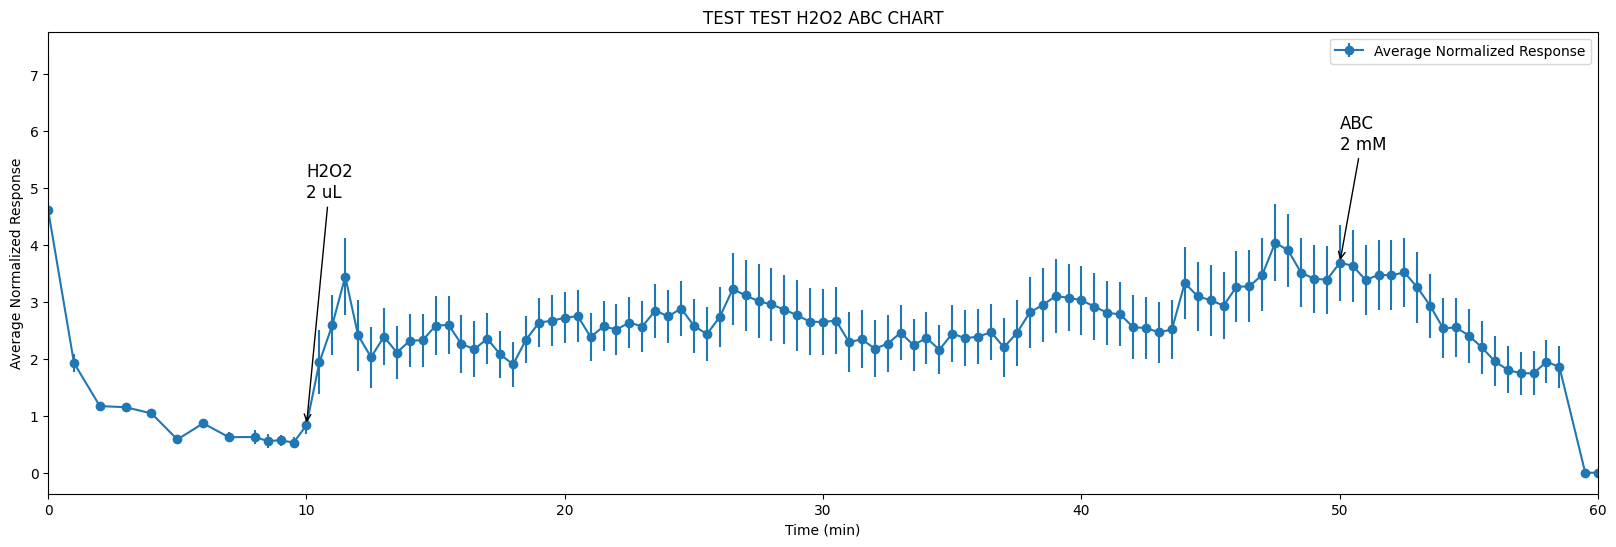

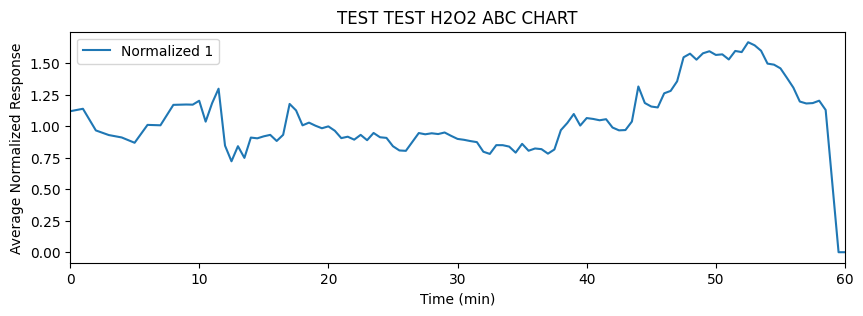

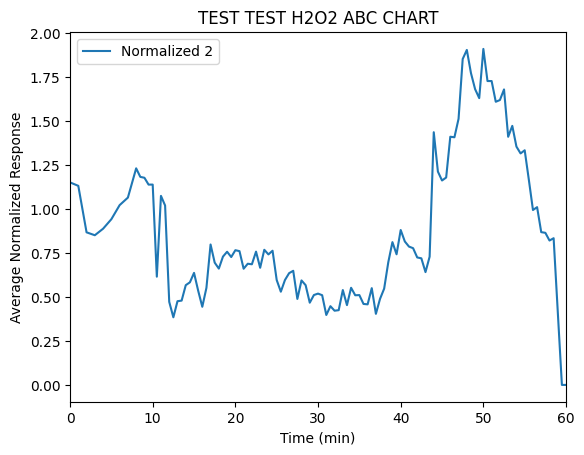

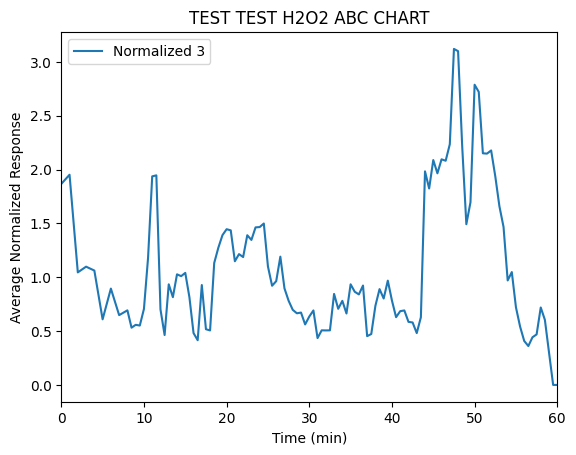

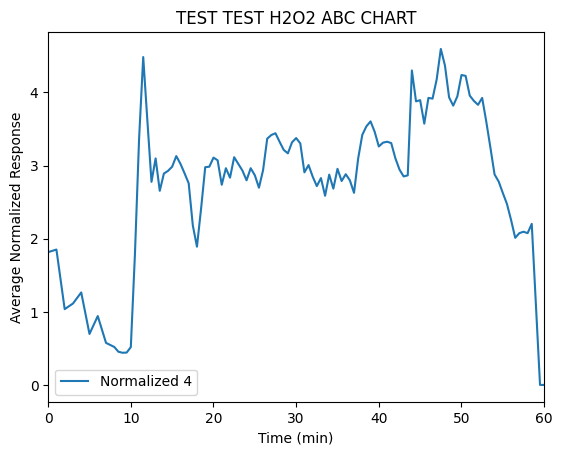

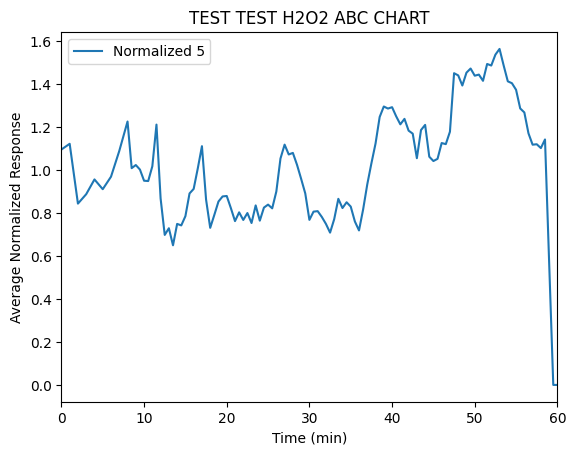

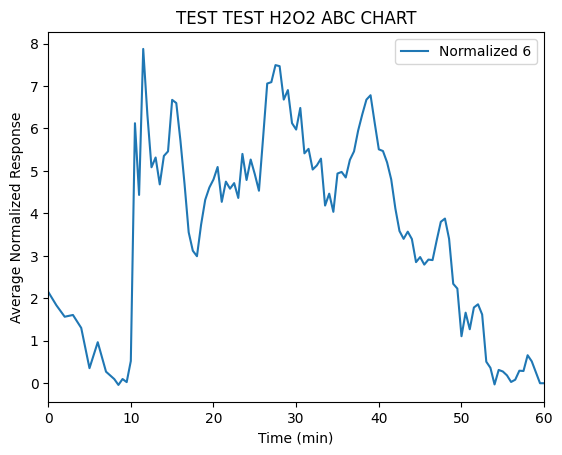

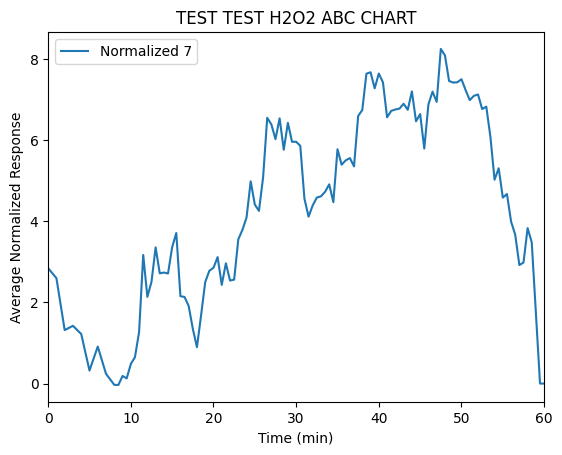

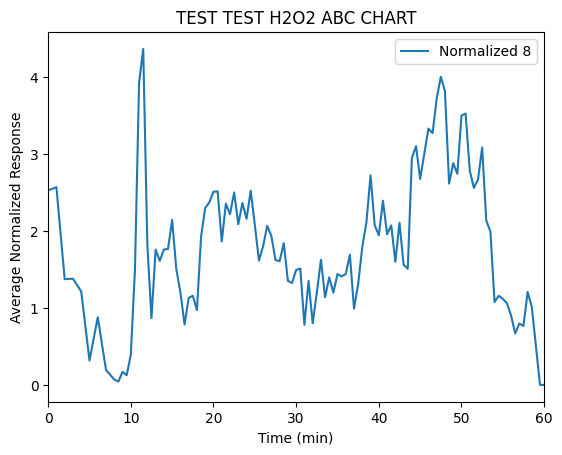

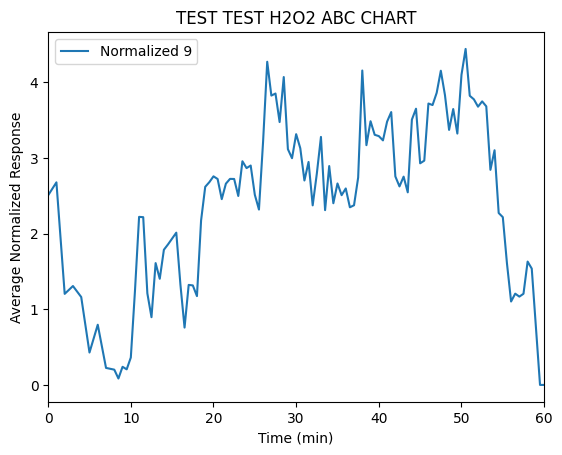

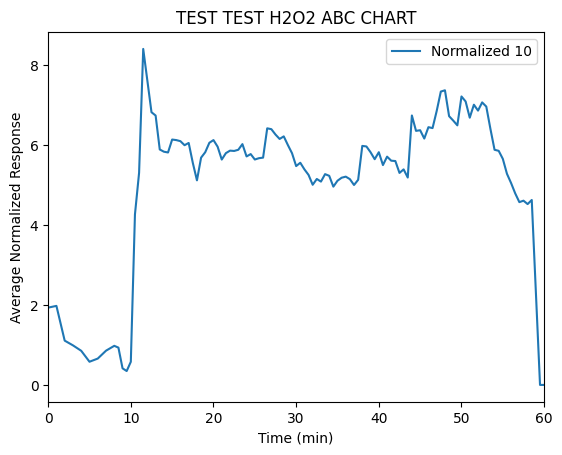

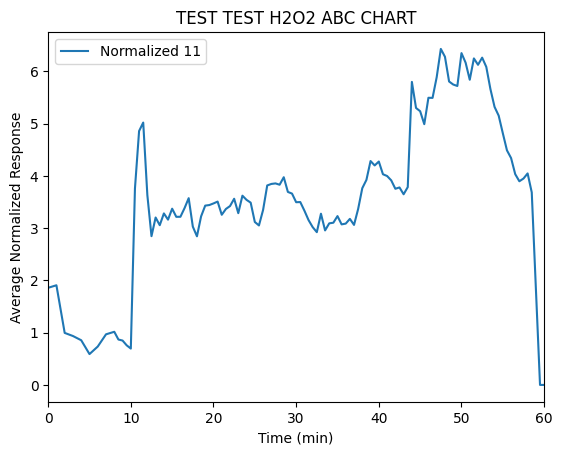

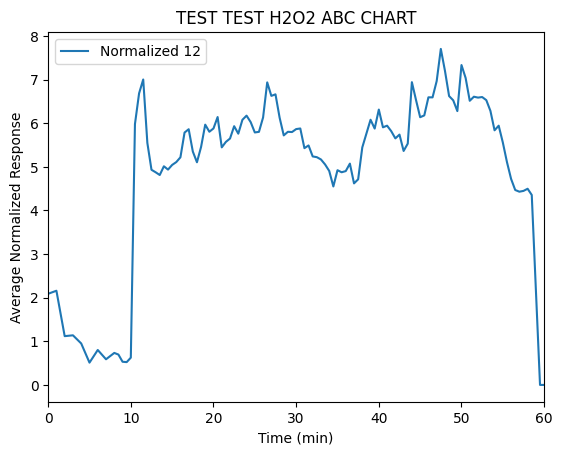

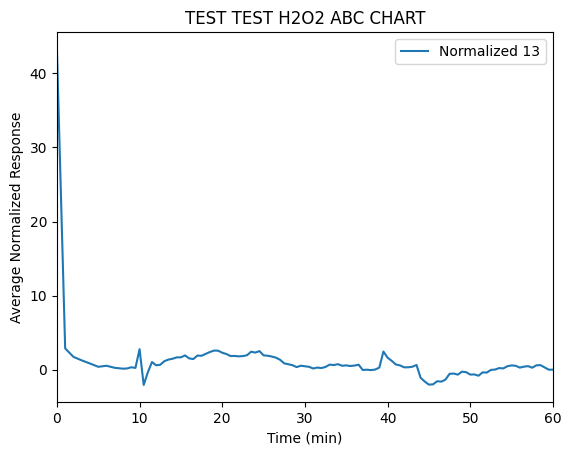

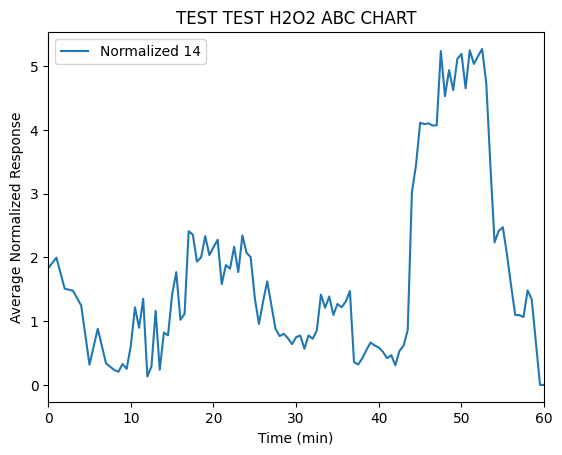

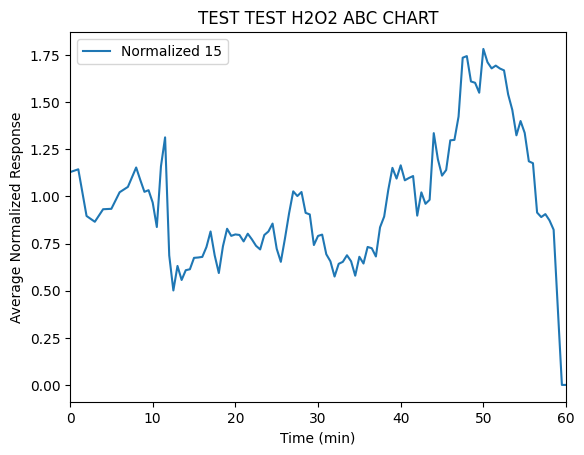

In [ ]:
time_values = summary_data['Time (min)']

summary_data['Time (min)'] = pd.to_numeric(summary_data['Time (min)'], errors='coerce')
summary_data['Average of Normalized'] = pd.to_numeric(summary_data['Average of Normalized'], errors='coerce')
summary_data['Std Error of Normalized'] = pd.to_numeric(summary_data['Std Error of Normalized'], errors='coerce')

summary_data = summary_data.dropna()

plt.figure(figsize=(20,6))
plt.errorbar(summary_data['Time (min)'], summary_data['Average of Normalized'], yerr=summary_data['Std Error of Normalized'], fmt='-o', label='Average Normalized Response')

plt.xlabel('Time (min)')
plt.ylabel('Average Normalized Response')
plt.title(chart_title)



plt.xlim(0, 60)

plt.legend()

activator_x = pd.to_numeric(activator_time, errors='coerce')  # Convert activator_time to numeric
activator_index = (summary_data['Time (min)'] - activator_x).abs().idxmin()  # Find the index corresponding to the target x-value
activator_y = summary_data['Average of Normalized'].loc[activator_index]
annotation_text = activator + '\n' + activator_qc

plt.annotate(annotation_text, xy=(activator_x, activator_y), xycoords='data', xytext=(activator_x, activator_y + 4),
             arrowprops=dict(facecolor='red', arrowstyle='->'), fontsize=12)

if inhibitor != 'NONE':
  inhibitor_x = pd.to_numeric(inhibitor_time, errors='coerce')
  inhibitor_index = (summary_data['Time (min)'] - inhibitor_x).abs().idxmin()  # Find the index corresponding to the target x-value
  inhibitor_y = summary_data['Average of Normalized'].loc[inhibitor_index]
  annotation_text = inhibitor + '\n' + inhibitor_qc

  plt.annotate(annotation_text, xy=(inhibitor_x, inhibitor_y), xycoords='data', xytext=(inhibitor_x, inhibitor_y + 2),
              arrowprops=dict(facecolor='red', arrowstyle='->'), fontsize=12)
plt.show()



normalized_columns = [col for col in summary_data.columns if col.startswith('Normalized')]

summary_data['Time (min)'] = pd.to_numeric(summary_data['Time (min)'], errors='coerce')
summary_data[normalized_columns] = summary_data[normalized_columns].apply(pd.to_numeric, errors='coerce')

summary_data = summary_data.dropna()

plt.figure(figsize=(10, 3))
for col in normalized_columns:
    plt.plot(summary_data['Time (min)'], summary_data[col], label=f'{col}')

    plt.xlabel('Time (min)')
    plt.ylabel('Average Normalized Response')
    plt.title(chart_title)
    plt.xlim(0, 60)

    plt.legend()

    plt.show()

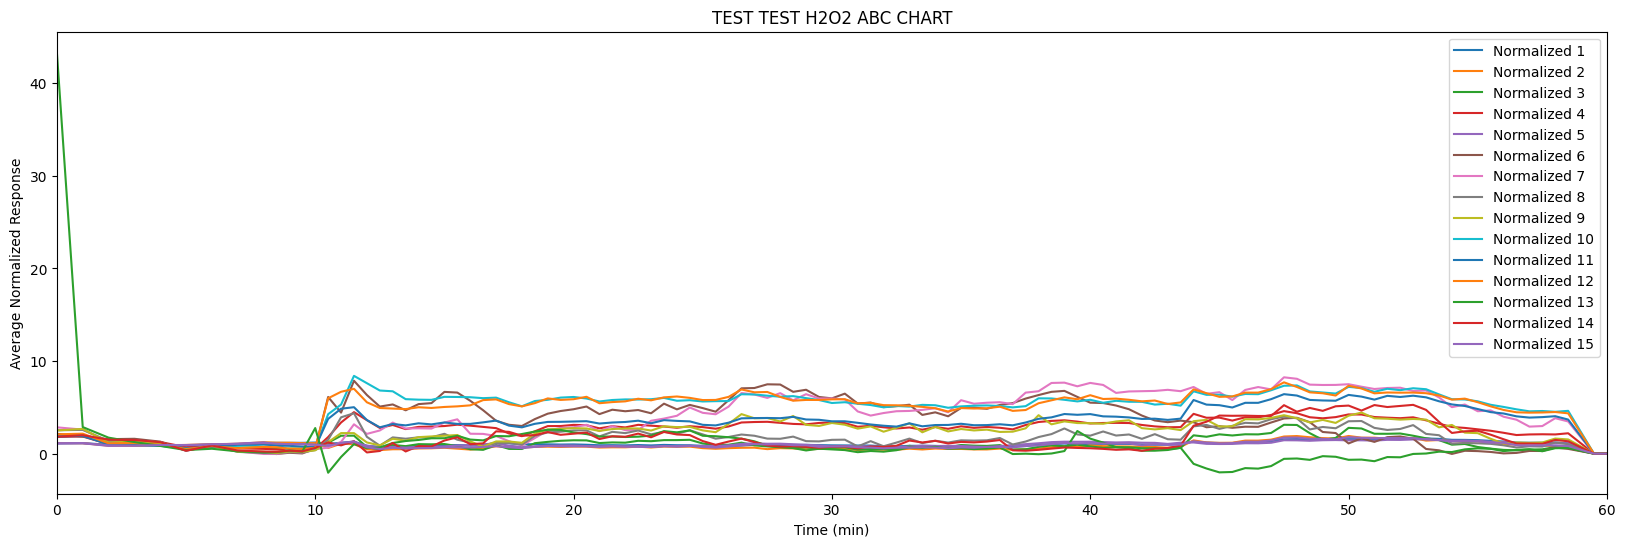

In [ ]:
summary_data['Time (min)'] = pd.to_numeric(summary_data['Time (min)'], errors='coerce')
summary_data[normalized_columns] = summary_data[normalized_columns].apply(pd.to_numeric, errors='coerce')

summary_data = summary_data.dropna()

plt.figure(figsize=(20, 6))
for col in normalized_columns:
    plt.plot(summary_data['Time (min)'], summary_data[col], label=f'{col}')

plt.xlabel('Time (min)')
plt.ylabel('Average Normalized Response')
plt.title(chart_title)
plt.xlim(0, 60)

plt.legend()

plt.show()

**Heatmap (use to determine which columns may be skewing the data)**

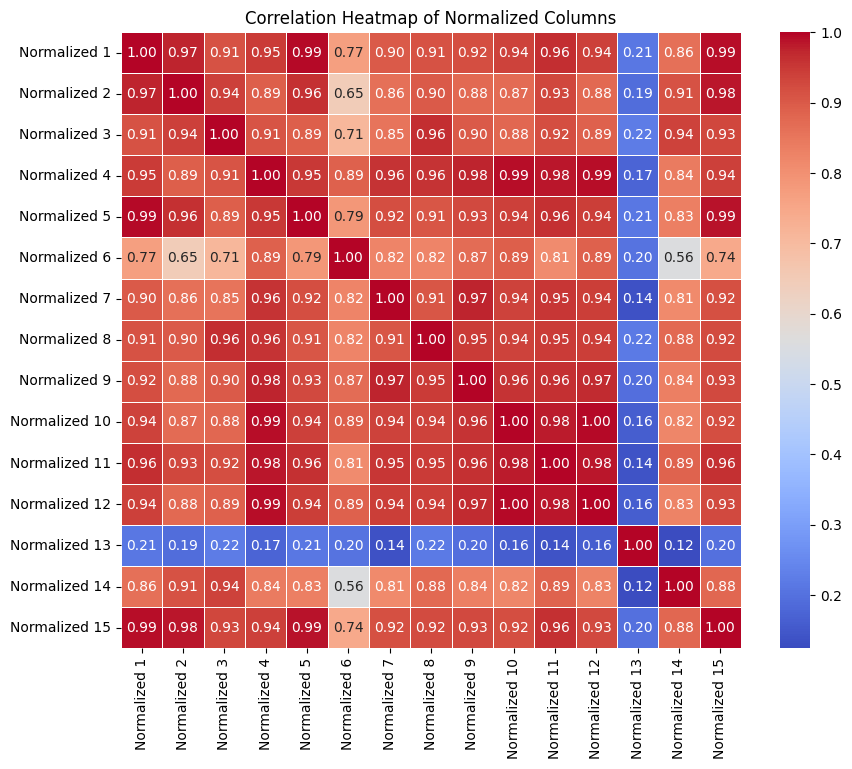

In [ ]:
correlation_matrix = summary_data[normalized_columns].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Correlation Heatmap of Normalized Columns')
plt.show()